# BayesOpt over the Infection Profile of  COVID carrier (Max R)

### Description
In this notebook we run bayesian optimisation (BO) over the \alpha and \beta parameters of the Gamma distribution defining the infection profile of a COVID carrier over 10 days corresponding to the number of days the simulation is run. The goal is to find the parameters that will maximise R (worst case)

Infection profile: probability of infecting a secondary contact on a given day. This basically corresponds to a a distribution of "infectivity",  i.e., when a carrier is most infectious. 

### Motivation
While there is already a specific distribution determined by He et al. 2020 characterising COVID carriers, the reason we perform this experiment is twofold:  i) to determine whether the result would follow intuition, i.e. perhaps being most infectious on the 10-th day is better than 1st day because you have more time to be detected and quarantined. ii) if not, try and interpret why?

### Results
Apparently, reaching pick infectiousness in the first days is the way to maximise R. This is expected as the first days of being infectious you are also more likely to come in contact with other people, since you are probably not in quarantine.

In [2]:
import os
import numpy as np
import pandas as pd
from   tqdm.notebook import trange
from   tti_explorer import config, utils
from   tti_explorer.case import simulate_case, CaseFactors
from   tti_explorer.contacts import EmpiricalContactsSimulator
from   tti_explorer.strategies import TTIFlowModel, RETURN_KEYS
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from   matplotlib import colors as mcolors
from   matplotlib import cm
import numpy as np
import GPy
from   emukit.core import ContinuousParameter, ParameterSpace
from   emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from   emukit.core.initial_designs import RandomDesign
from   GPy.models import GPRegression
from   emukit.model_wrappers import GPyModelWrapper
from   emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from   emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from   emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai
import pandas as pd
from   tti_explorer.strategies import TTIFlowModel
from GPyOpt.methods import BayesianOptimization
from scipy.stats import gamma

def print_doc(func):
    print(func.__doc__)
rng = np.random.RandomState(0)

def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")
path_to_bbc_data = os.path.join("../../data", "bbc-pandemic")


In [3]:
def update_inf_profile(alpha, beta):
    case_config['inf_profile']=he_infection_profile(10, gamma_params={"a": alpha, "scale": 1 / beta})
    return case_config
    
    
def he_infection_profile(period, gamma_params):
    """he_infection_profile

    Args:
        period (int): length of infectious period
        gamma_params (dict): shape and scale gamma parameters
        of infection profile

    Returns:
        infection_profile (np.array[float]): discretised and
        truncated gamma cdf, modelling the infection profile
        over period
    """
    inf_days = np.arange(period)
    mass = gamma.cdf(inf_days + 1, **gamma_params) - gamma.cdf(inf_days, **gamma_params)
    return mass / np.sum(mass)


In [4]:

"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    pol_configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
#simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)


def run_tti_sim(pol_configs):
    to_return=[]
    for vals in pol_configs:
        case_config = update_inf_profile(vals[0], vals[1])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        rng = np.random.RandomState(42)
        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)

In [5]:

s_levels=['S1_symptom_based_TTI','S2_symptom_based_TTI','S3_symptom_based_TTI','S4_symptom_based_TTI','S5_symptom_based_TTI',]

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
cidx=0
cols = ['red', 'tomato', 'orange', 'deepskyblue', 'green']


def optimise_BO(strig):
    kern_eq = GPy.kern.RBF(input_dim=2, ARD = True) + GPy.kern.White(input_dim=2, variance=1)
    kern_bias = GPy.kern.Bias(input_dim=2)
    kern = kern_eq + kern_bias
    domain = [
    {'name': 'alpha', 'type': 'continuous', 'domain': (0.1,5)},
    {'name': 'beta', 'type': 'continuous', 'domain': (0.1,5)}]
    opt = BayesianOptimization(f=run_tti_sim, maximize=True, domain=domain,model_type='GP', initial_design_numdata = 20,
    kernel=kern, acquisition_type='EI')
    out_name="bo-inf-profile-min-R/bo-infectious-min-{}.txt".format(strig)
    opt.run_optimization(max_iter=20, report_file=out_name)

for strigency in s_levels:
    case_config = config.get_case_config("delve")
    contacts_config = config.get_contacts_config("delve")
    policy_config = config.get_strategy_configs("delve", strigency)[strigency]
    factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
    strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
    rng = np.random.RandomState(42)

    tti_model = TTIFlowModel(rng, **strategy_config)

#    run_sensitivity(strigency, 100, 10, 10000, cols[cidx])
    optimise_BO(strigency)
    cidx+=1


# S1 Inf Prof Gamma Distr.

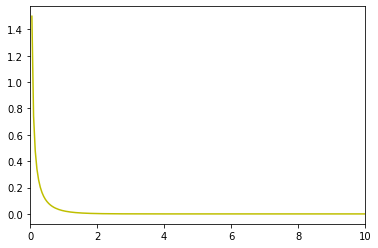

In [14]:
x = np.linspace (0, 10, 200) 
y1 = gamma.pdf(x, a=0.1, scale=1/1.55859915) 
plt.plot(x, y1, "y-") 
plt.xlim([0,10])
plt.show()



# S2 Inf Prof Gamma Distr.

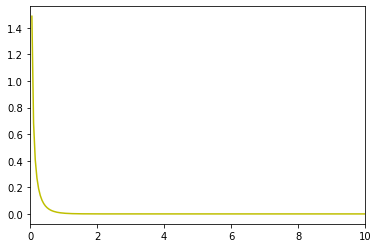

In [15]:
x = np.linspace (0, 10, 200) 
y1 = gamma.pdf(x, a=0.1, scale=1/3.04) 
plt.plot(x, y1, "y-") 
plt.xlim([0,10])
plt.show()


# S3 Inf Prof Gamma Distr.

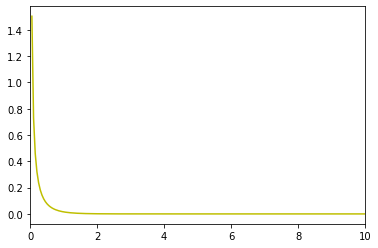

In [17]:
x = np.linspace (0, 10, 200) 
y1 = gamma.pdf(x, a=0.1, scale=1/1.99) 
plt.plot(x, y1, "y-") 
plt.xlim([0,10])
plt.show()



# S4 Inf Prof Gamma Distr.

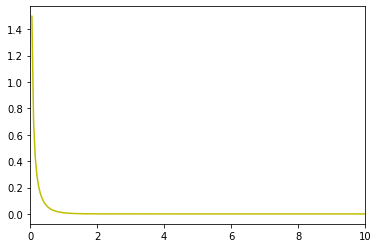

In [19]:
x = np.linspace (0, 10, 200) 
y1 = gamma.pdf(x, a=0.1, scale=1/2.58) 
plt.plot(x, y1, "y-") 
plt.xlim([0,10])
plt.show()



# S5 Inf Prof Gamma Distr.

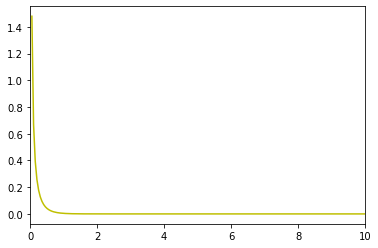

In [18]:
x = np.linspace (0, 10, 200) 
y1 = gamma.pdf(x, a=0.1, scale=1/3.34) 
plt.plot(x, y1, "y-") 
plt.xlim([0,10])
plt.show()

